In [1]:
import lalpulsar
import lal
import soap
import numpy as np
#import sftscripts
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.signal import spectrogram, medfilt, boxcar
import subprocess
from lalpulsar import simulateCW
from soapcw import cw
import sys
sys.path.append("/Users/josephbayley/projects/soap_scripts/s6_tests/")
import load_data

In [2]:
#%matplotlib notebook

In [3]:
data_dir = "/Volumes/LaCie/data/soap/"

## load parameters for particular source 

In [4]:
fmin,fmax = 180.2,180.3
par_filenames=["/Volumes/LaCie/data/soap/s6/s6_mdc/SNR_table.txt"]
par_filename = ["/Users/josephbayley/projects/"]
inj = load_data.read_all(fmin,fmax,filenames=par_filenames)
tstart,T,tsft = 931035615.,22538,1800.
bins = np.arange(fmin,fmax,0.05)
params_doppler = lalpulsar.PulsarDopplerParams()
params_amp = lalpulsar.PulsarAmplitudeParams()
snrH,snrL = 0,0
parfilepath = "/Volumes/LaCie/data/soap/parfiles/"
p_params = []
par = []
for i in inj:
    #print i
    try:
        pname = i["PSR"]
        par = load_data.get_pulsar_params(parfilepath + pname[1:] + '.par')
        p_params = par["Alpha"],par["Delta"],par["phi0"],par["psi"],par["cosi"],par["f"],par['h0']
    except:
        pname = i["#Pulsar"]
        p_params = i["rightascension"], i["declination"], i["phi0"], i["psi"], np.cos(i["iota"]), [i["Frequency"], i["fdot"]], i["h0"]
    snrH = i["SNR(H1)"]
    snrL = i["SNR(L1)"]

    det_name = 'H1'
    params_doppler.fkdot[0] = p_params[5][0]
    params_doppler.fkdot[1] = p_params[5][1]
    params_doppler.refTime  = tstart
    params_doppler.Alpha    = p_params[0]
    params_doppler.Delta    = p_params[1]
    
    params_amp.cosi = p_params[4]
    params_amp.h0 = p_params[6]
    params_amp.phi0 = p_params[2]
    params_amp.psi = p_params[3]


# Inject from time series

In [14]:
def waveform(h0, cosi, freq, f1dot):
    def wf(dt):
        dphi = lal.TWOPI * (freq * dt + f1dot * 0.5 * dt**2)
        ap = h0 * (1.0 + cosi**2) / 2.0
        ax = h0 * cosi
        return dphi, ap, ax
    return wf

In [15]:
# set up parameters
tref     = tstart #900043200
h0       = params_amp.h0*40
cosi     = params_amp.cosi
psi      = params_amp.psi
phi0     = params_amp.phi0
freq     = params_doppler.fkdot[0] + 0.8/1800.
f1dot    = params_doppler.fkdot[1]
dt_wf    = 1./4096
alpha    = params_doppler.Alpha
delta    = params_doppler.Delta
detector = 'H1'
sh       = 1.2918440718232042e-45

In [16]:
sig = cw.GenerateSignal()
sig.get_edat()

In [206]:
# generate waveform
wf = waveform(h0, cosi, freq, f1dot)
S = simulateCW.CWSimulator(tref, tstart, 1*tsft, wf, dt_wf, phi0, psi, alpha, delta, detector,earth_ephem_file=sig.earth_ephem,sun_ephem_file=sig.sun_ephem)

In [207]:
# generate same waveform in and out of noise
ltime,signal = S.get_strain(4096)
ltime,signoise = S.get_strain(4096,noise_sqrt_Sh=np.sqrt(sh))

In [208]:
# get noise by subtracting signal from noise
noise = signoise-signal

In [209]:
# create spectrograms of signal and noise
f,t,signoise_spect = spectrogram(signoise.astype(float),fs = 4096, nperseg=int(tsft*4096),noverlap=0,window=("boxcar"))

In [210]:
# generate spectrograms for noise and signal
fsig,tsig,sig_spect = spectrogram(signal,fs = 4096., nperseg=int(tsft*4096),noverlap=0.0,window=("boxcar"))
f_noise,t_noise,noise_spect = spectrogram(noise.astype(float),fs = 4096. , nperseg=int(tsft*4096), noverlap=0.0,window=("boxcar"))

Get the noise floor and SNR from ffts of timeseries

In [211]:
padsig = signal#np.append(signal,np.zeros(20*len(signal)))

In [212]:
# window with boxcar
bcar = boxcar(len(padsig))

In [213]:
# signal fft
fftsig = np.fft.rfft(padsig*bcar)

In [214]:
freqsig = np.fft.rfftfreq(len(padsig),1./4096.)

In [215]:
# signal spectrogram
sp_sig = 2*np.array(np.abs(fftsig)**2)/(len(padsig)*4096) # Factor for 2 here as one sided 

In [230]:
# noise fft and spectrogram
fftnoise = np.fft.rfft(noise)
sp_noise = 2*np.abs(fftnoise)**2/(len(fftnoise)*4096.)

In [231]:
print("calcualted_noise",np.mean(sp_noise))
print("input_noise     ",sh)

calcualted_noise 2.5827255025812465e-45
input_noise      1.2918440718232042e-45


In [232]:
# snr calculation from spectrograms 
snr = 0
for i in range(1):
    snr += np.sum(sig_spect[:,i]/noise_spect[:,i])
print(np.sqrt(snr))

26.19087279090296


In [233]:
print(np.sqrt(np.sum(sp_sig/sp_noise))) 

20.91132900206107


In [234]:
# empirical snr calculation from ffts
snr = np.sum(sp_sig)/sh
print(np.sqrt(snr))

24.45627637429613


Get the SNR and noise floor from spectrograms simulation

In [108]:
sig = cw.GenerateSignal()
sig.alpha = alpha
sig.delta = np.arcsin(delta)
sig.cosi = cosi
sig.phi0 = phi0
sig.psi = psi
sig.f = [freq + 0.4/1800.,f1dot]
sig.tref = tref
sig.h0 = h0

In [109]:
data = sig.get_spectrogram(tstart = tstart, nsft = 1,tsft=1800,fmin=freq-0.05,fmax=freq+0.05,dets= ["H1"],Sn={"H1":sh})

signal SNR

In [110]:
stfreq  = sig.get_pulsar_path([tstart],'H1')

In [235]:
# "analytical" calculation of SNR 
snr = sig.get_snr2(tstart=tstart,tsft=1800.,nsft=1,det="H1",Sn=sh, h0=sig.h0)

In [236]:
print(np.sqrt(snr))

[24.9542714]


In [113]:
fullfreqs = np.arange(0,180.3,1./1800)
freqvals = np.linspace(fullfreqs[np.argmin(np.abs(fullfreqs-180.2))],fullfreqs[-1],5000)
values = data.fresnel_power(freqvals,stfreq,1800.,f1dot)*snr

In [114]:
#maxval = max(2*sig_spect[fmin_ind1:fmax_ind1,0]/sh)

In [115]:
#diff = np.linspace(180.2,180.3,10000)[np.argmin(np.abs(values - maxval))] - fsig[fmin_ind1:fmax_ind1][np.argmin(np.abs(2*sig_spect[fmin_ind1:fmax_ind1,0]/sh - maxval))]
                                                                                               

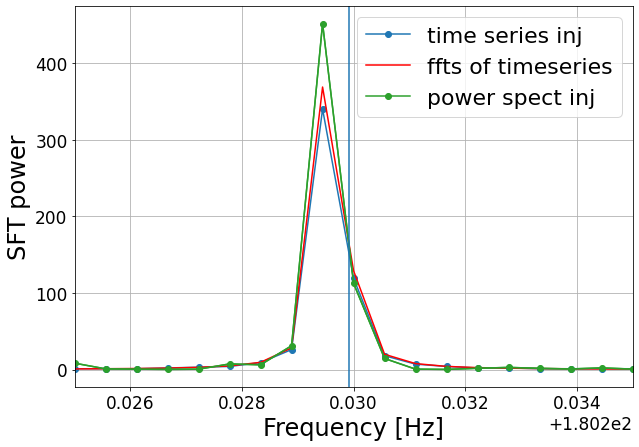

In [117]:
fig,ax = plt.subplots(figsize=(10,7))


fmin_ind = np.where(freqsig == fmin)[0][0]#np.argmin(np.abs(freqsig-fmin))#np.where(freqsig == fmin)[0][0]
fmax_ind = np.where(freqsig == fmax)[0][0]#np.argmin(np.abs(freqsig-fmin))#np.where(freqsig == fmax)[0][0]
fmin_ind1 = np.where(fsig == fmin)[0][0]
fmax_ind1 = np.where(fsig == fmax)[0][0]
#ax.plot(fsig[fmin_ind1:fmax_ind1],2*sig_spect[fmin_ind1:fmax_ind1,0]/sh,color="C0")
ax.plot(fsig[fmin_ind1:fmax_ind1],sig_spect[fmin_ind1:fmax_ind1,0]/sh,label="time series inj",marker="o",color="C0")
ax.plot(freqsig[fmin_ind:fmax_ind],sp_sig[fmin_ind:fmax_ind]/sh,"r",label="ffts of timeseries")
#ax.plot(freqvals ,np.array(values),color="C1")

ax.plot(data.H1.frequencies,data.H1.norm_sft_power[0],color="C2")
ax.plot(data.H1.frequencies,data.H1.norm_sft_power[0],label="power spect inj",color="C2",marker="o")
#ax.plot(my_data[0][0])
#ax.plot(noise_spect[:,0])
#ax.plot(signoise[:100])
#ax.plot(noise[:100])
#ax.plot(np.abs(np.fft.rfft(noise[:int(0.5*len(noise))]))**2)
#ax.axvline(my_data[1][0],color="r")
#ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("SFT power")
#ax.set_xlim(fmin,fmax)
ax.set_xlim(180.225,180.235)
ax.axvline(stfreq)
ax.legend()

In [118]:
max(sp_sig[fmin_ind:fmax_ind]),max(values)

(4.764046906737577e-43, 622.7003772289039)

In [119]:
max(sp_sig[fmin_ind:fmax_ind]/sh)

368.7787876762857

No handles with labels found to put in legend.


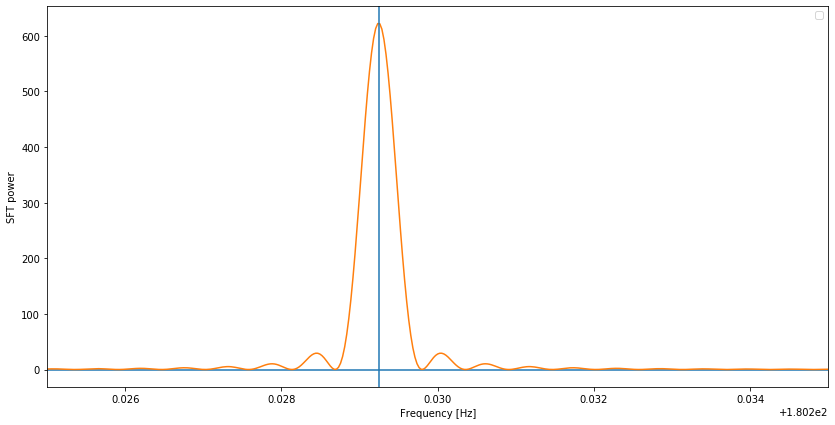

In [94]:
fig,ax = plt.subplots(figsize=(14,7))

fmin_ind = np.argmin(np.abs(freqsig-fmin+0.05))#np.where(freqsig == fmin)[0][0]
fmax_ind = np.argmin(np.abs(freqsig-fmax-0.05))#np.where(freqsig == fmax)[0][0]
fmin_ind1 = np.where(fsig == fmin)[0][0]
fmax_ind1 = np.where(fsig == fmax)[0][0]

#ax.plot(freqsig,fftsig,label="time series inj",marker="o",color="C0")
dt = (freqsig[2] -freqsig[1])
ax.plot(freqsig[fmin_ind:fmax_ind] ,2*sp_sig[fmin_ind:fmax_ind]/sh,color="C0")

freqvals = freqsig[fmin_ind:fmax_ind]
values = sig.fresnel_power(freqvals,stfreq,1800.,f1dot)*snr

ax.plot(freqvals ,np.array(values),color="C1")

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("SFT power")
#ax.set_xlim(fmin,fmax)
ax.set_xlim(180.225,180.235)
ax.axvline(stfreq)
ax.legend()

In [17]:
soap.gen_data.fresnel_power?

<IPython.core.display.Javascript object>


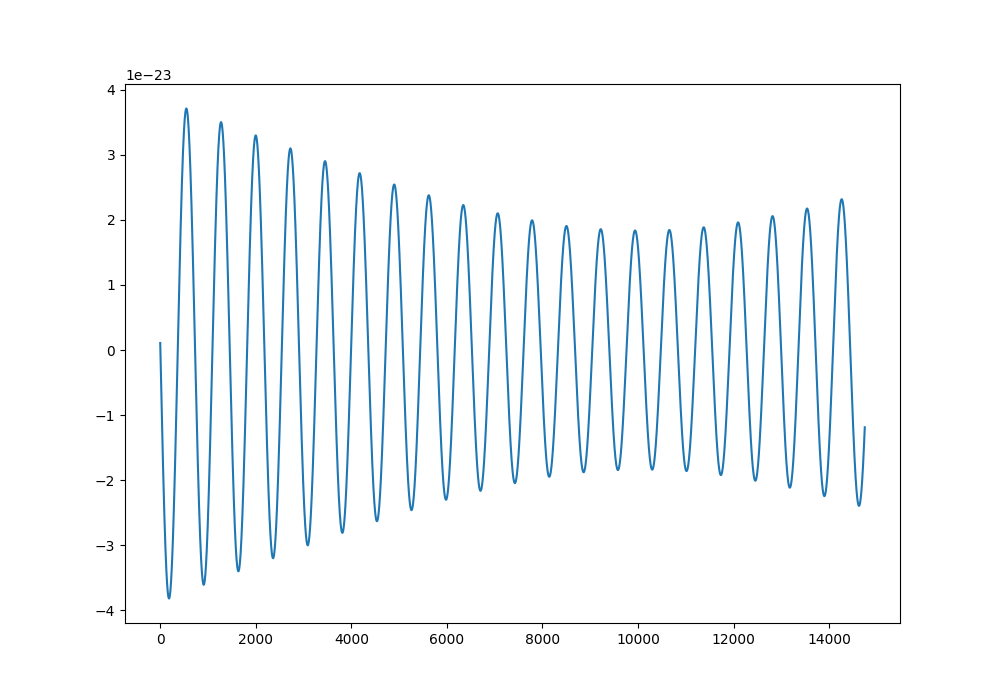

In [169]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(signal[::1000])

## Sine wave and sinc function

In [254]:
freq_sin = 50
nsamp = 1000
xvals = np.linspace(0,1,nsamp)
fs = 1/(1/nsamp)
sinvals = np.append(np.sin(2*np.pi*freq_sin*xvals),np.zeros(10000))
xvals2 = np.linspace(0,2,len(sinvals))

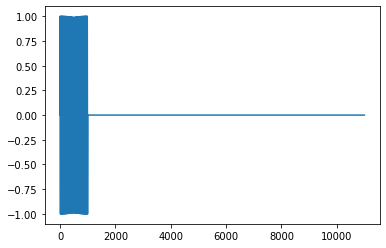

In [255]:
fig, ax = plt.subplots()
ax.plot(sinvals)

In [274]:
powspec = np.abs(np.fft.rfft(sinvals)**2)
powfreq = np.fft.rfftfreq(len(sinvals),1./fs)

In [322]:
dt = powfreq[10] - powfreq[9]

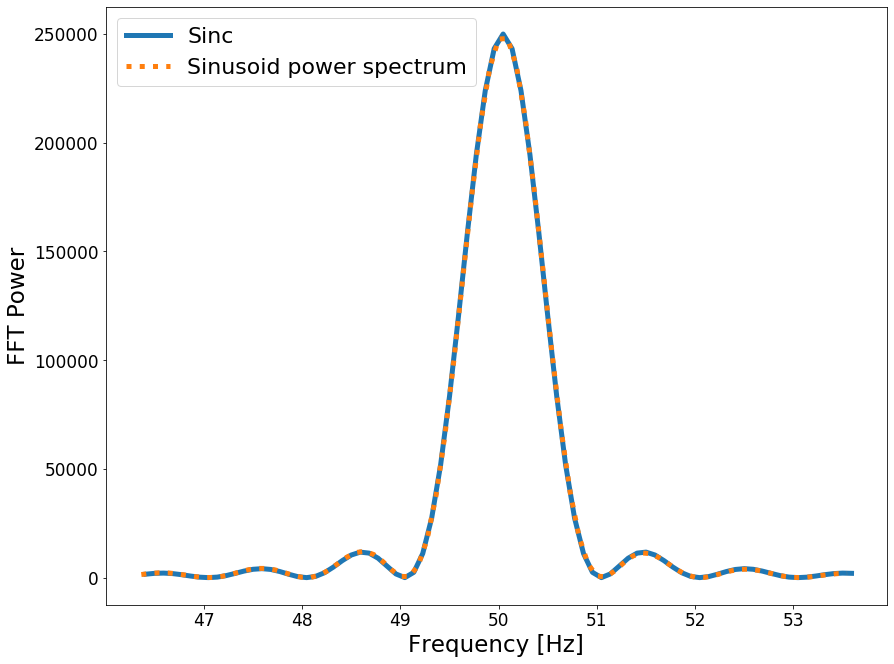

In [343]:
fig, ax = plt.subplots(figsize=(14,11))
fontsize = 23
fstind,fenind = 510,590
sincx = powfreq[fstind:fenind]
sinc = np.abs(np.sinc(powfreq[fstind:fenind] - freq )*0.5*fs)**2
ax.plot(powfreq[fstind:fenind] + 0.5*dt,sinc,ls="-",lw=5,label="Sinc")
ax.plot(sincx,powspec[fstind:fenind],lw=5,ls=":",label="Sinusoid power spectrum")
#ax.plot(powfreq,powspec)
ax.legend(fontsize=fontsize-1)
ax.set_xlabel("Frequency [Hz]",fontsize=fontsize)
ax.set_ylabel("FFT Power",fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=17)


In [344]:
fig.savefig("/Users/josephbayley/projects/thesis/AppendixA/sinc_fft.pdf",format="pdf",bbox_inches="tight")

# Sin with spindown

Start with definition of fourier transform as in [https://iopscience.iop.org/article/10.1086/342285/meta].
Discrete Fourier transform,
\begin{equation}
 A_k = \sum_{j = 0}^{N-1} n_j e^{-i2 \pi j k/N},
\end{equation}
the frequency of kth element is,
\begin{equation}
f_k = \frac{k}{N dt} = \frac{k}{T}
\end{equation}
where k is the frequency bin number, N is the number of data points, T is the total time duration.
The frequency spacing is $1/T$, $N/2T$ is the nyquist frequency.

Can then define a value $u$, this is the fraction of time between the start and end of observation.
i.e T becomes 1. and $u = t/T$, so $0 \leq u \leq 1$.
this also means that $f = r/T$ and $\dot{f}=\dot{r}T^2$
One can then define the continuous Fouier transform (if large data) in terms of $u$ as,
\begin{equation}
A_r = N \int^{1}_{0} n(u) e^{-i2 \pi r u} du.
\end{equation}

For a sinusoid which has some frequency derivative the Fourier transform changes slightly. 
One can start with the definition of a signal with a constant frequency derivative such that
\begin{equation}
 f = f_0 + \dot{f} t ,
\end{equation}
where $f$ is its frequency, $f_0$ is the center frequency, $\dot{f}$ is its frequent derivative and $t$ is time.
The signal can then be written as
\begin{equation}
\begin{split}
n(t) &= a \exp{\left[2\pi \int_0^t f(t) dt + \phi\right]}, \\
&= a \exp{\left[2\pi (f_0 t +  \frac{\dot{f}}{2} t^2)  + \phi\right]}, \\
\end{split}
\end{equation}
where $\phi$ is some extra phase..
In cases that follow we will have a finite length of data, we can center this around a time of zero; this is equivalent to applying a box window the signal.
If we define the length of our signal as $T$ we can say that the signal $n(t) = 0$ outside of $-T/2 \leq t \leq T/2$.
The Fourier transform can then be written as
\begin{equation}
\begin{split}
\tilde{n}(f) &= \frac{a}{2}  \int_{-T/2}^{T/2} n(t) \exp{\left\{ -i 2 \pi t f\right\}} dt \\
&= \frac{a}{2} e^{i\phi} \int_{-T/2}^{T/2} e^{i 2 \pi \left(\frac{\dot{f}}{2} t^2 + f_{0}t - ft \right)} dt  \\
&= \frac{a}{2} e^{i\phi} \left[  I  \right]. \\
\end{split}
\end{equation}
The integral can then be written as,
\begin{equation}
\begin{split}
I &= \int_{-T/2}^{T/2} \exp{\left\{i 2 \pi \left(\frac{\dot{f}}{2} t^2 + f_{0}t - f \right) \right\}} dt \\
&= \int_{-T/2}^{T/2} \exp{\left\{ i 2 \pi\left(\frac{\dot{f}}{2} t^2 + (f - f_{0})t \right) \right\}} dt \\
& = \int_{-T/2}^{T/2} \exp{\left\{i \frac{\pi}{2} 2 \dot{f} \left(t^2 + 2\frac{(f - f_0)}{\dot{f}}t \right)\right\}} dt \\
& = \int_{-T/2}^{T/2} \exp{\left\{i \frac{\pi}{2} 2 \dot{f} \left[\left(t + \frac{(f - f_0)}{\dot{f}} \right)^2 - \left(\frac{(f - f_0)}{\dot{f}}\right)^2 \right]\right\}} dt \\
& = \exp{\left\{  - i \frac{\pi}{2} 2 \dot{f} \left(\frac{(f - f_0)}{\dot{f}}\right)^2 \right\}}\int_{-T/2}^{T/2} \exp{\left\{i \frac{\pi}{2} 2 \dot{f} \left[\left(t + \frac{(f - f_0)}{\dot{f}} \right)^2 \right]\right\}} dt \\
\end{split}
\end{equation}
We can then substitute using
\begin{equation}
v = \sqrt{2\dot{f}}\left( t - \frac{(f-f_0)}{\dot{f}}  \right)
\end{equation}
where,
\begin{equation}
dv = \sqrt{2\dot{f}} dt. 
\end{equation}
The integral then becomes,
\begin{equation}
I  = \exp{\left\{  - i \frac{\pi}{2} 2 \dot{f} \left(\frac{(f - f_0)}{\dot{f}}\right)^2 \right\}}\int_{-V_l}^{V_u} \exp{\left\{i \frac{\pi}{2} v^2\right\}} dv
\end{equation}
When $t = -T/2$ and $t=T/2$ we can define the limits of the integral $V_l$ and $V_u$ respectively as
\begin{equation}
\begin{split}
V_l &= \sqrt{2\dot{f}}\left( \frac{T}{2} + \frac{(f - f_0)}{\dot{f}}  \right) \\
V_u &= \sqrt{2\dot{f}}\left( \frac{T}{2} - \frac{(f - f_0)}{\dot{f}}  \right). \\
\end{split}
\end{equation}
As the $\sin(v^2)$ function is symmetric, this integral can be split up further such that
\begin{equation}
\begin{split}
I &= \exp{\left\{  - i \frac{\pi}{2} 2 \dot{f} \left(\frac{(f-f_0)}{\dot{f}}\right)^2 \right\}}  \frac{1}{\sqrt{2\dot{f}}}  \\ 
&. \left[\int_{0}^{V_u} \exp{\left\{i \frac{\pi}{2} v^2\right\}} dv\right. + \left. \int_{0}^{V_l} \exp{\left\{i \frac{\pi}{2} v^2\right\}} dv\right].  \\
\end{split}
\end{equation}
One can then use the Fresnel $S(x)$ and $C(x)$ defined by
\begin{equation}
\begin{split}
C(x) &= \int_0^x \cos{\frac{\pi}{2} t^2} dt \\
S(x) &= \int_0^x \sin{\frac{\pi}{2} t^2} dt \\
\end{split}
\end{equation}
The Fourier transform is then,
\begin{equation}
\tilde{n}(f) = \frac{a}{2\sqrt{2\dot{f}}} \exp{ \left\{ i(\phi - \pi \frac{f - f_0}{\dot{f}}) \right\} } \left[ C(V_l) + C(V_u) + i(S(V_l) + S(V_u))   \right],
\end{equation}
where,
The power spectrum is then
\begin{equation}
|\tilde{n}(f)|^2 = \frac{a^2}{4|\dot{f}|}  \left[ (C(V_l) +  C(V_u))^2 + (S(V_l) + S(V_u))^2   \right]
\label{app1:power_fresnel}
\end{equation}

In [39]:
from scipy.special import fresnel

In [48]:
def fresnel_power(f,f0c,tsft,fdot):
    
    fdot = np.abs(fdot)
    Y = np.sqrt(fdot/2.0)*tsft*(1+(2.0*(f-f0c)/(fdot*tsft)))
    Z = np.sqrt(fdot/2.0)*tsft*(1-(2.0*(f-f0c)/(fdot*tsft)))
    
    S1,C1 = fresnel(Y)
    S2,C2 = fresnel(Z)
    Sw2 = (1/(2*fdot*tsft*tsft))*((C1+C2)**2 + (S1+S2)**2) 
  
    return Sw2

In [47]:
fresnel_power(100,101,1800,0)

/Users/josephbayley/.virtualenvs/soap/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/josephbayley/.virtualenvs/soap/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Users/josephbayley/.virtualenvs/soap/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/josephbayley/.virtualenvs/soap/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/josephbayley/.virtualenvs/soap/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':


nan

In [49]:
f = 200.
fdot = 1e-9
fs = 4000.
dt = 1./fs
tlen = 18.
tstart = 0.
datalen = fs*tlen
fc = f + fdot*(tstart + tlen)

In [50]:
print(f,fc)

200.0 200.000000018


Generate time from 0-18s at a sampling rate of 4000 Hz
Make a sinusiod signal following equations above

In [51]:
t = np.linspace(tstart,tlen,datalen).astype("float")
nt = np.exp(1j*2*np.pi*(f*t + fdot*t*t*0.5))

Pad with zeros for a higher resolution in frequency.

In [52]:
padnt = np.append(nt,np.zeros(900000))

Get the power spectrum from the fft and the frequencies they correspond to

In [46]:
fs/len(padnt) * 

SyntaxError: invalid syntax (<ipython-input-46-30b2aa9ec482>, line 1)

In [53]:
nf = np.abs(np.fft.fft(padnt))**2
frs = np.fft.fftfreq(len(padnt),dt)

In [54]:
diff = frs[1] - frs[0]

In [55]:
diff

0.00411522633744856

In [56]:
pws = fresnel_power(frs,fc,tlen,fdot)*datalen*datalen

In [57]:
stbin,enbin = int((fc - 0.1)*1./diff),int((fc + 0.1)*1./diff)

In [58]:
maxfreqnf  = frs[np.argmax(nf)]
maxfreqpws = frs[np.argmax(pws)]

In [59]:
print(maxfreqnf,maxfreqpws)
print((maxfreqnf - maxfreqpws))

200.00411522633746 200.00000000000003
0.004115226337432887


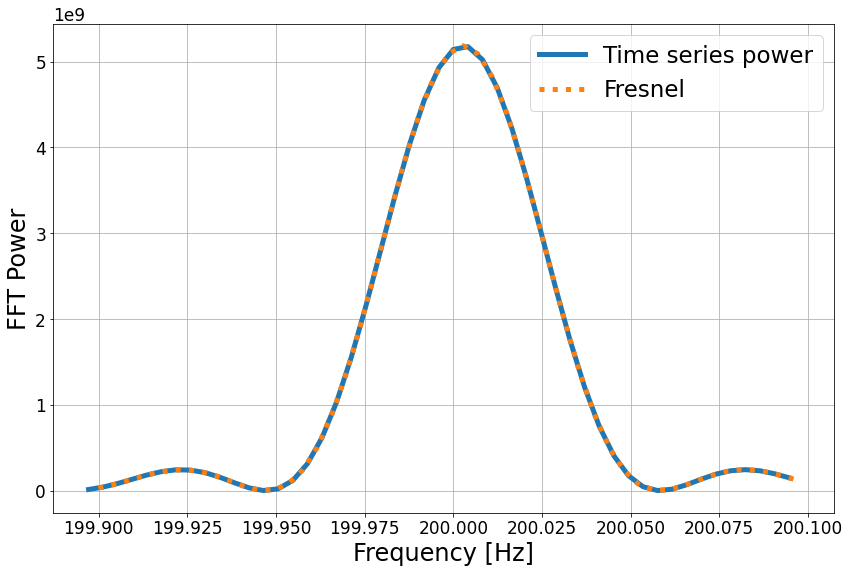

In [71]:
fig, ax = plt.subplots(figsize=(14,9))
fontsize=24
ax.plot(frs[stbin:enbin],nf[stbin:enbin],label="Time series power",lw=5)
ax.plot(frs[stbin:enbin] + 5/1800.,pws[stbin:enbin],label="Fresnel",ls=":",lw=5)
#ax.axvline(maxfreqnf)
#ax.axvline(maxfreqpws,color="C1")
ax.legend(fontsize=fontsize-1)
ax.set_xlabel("Frequency [Hz]",fontsize=fontsize)
ax.set_ylabel("FFT Power",fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=17)

In [72]:
fig.savefig("/Users/josephbayley/projects/thesis/AppendixA/fresnel_fft.pdf",format="pdf",bbox_inches="tight")

In [59]:
from scipy.optimize import curve_fit

In [1395]:
fdots = np.logspace(-1,-12,100)
fdot_diff = np.zeros(len(fdots))
for i,fdot in enumerate(fdots):
    
    nt = np.cos(2*np.pi*(f*t + fdot*t*t/2.))
    padnt = np.append(nt,np.zeros(900000))
    nf = np.abs(np.fft.rfft(padnt))**2
    frs = np.fft.rfftfreq(len(padnt),dt)
    
    diff = frs[1] - frs[0]
    stbin,enbin = int((f - 0.4)*1./diff),int((f + 0.4)*1./diff)
    
    pws = fresnel_power(frs,f,tlen,fdot)*datalen*datalen/4
    
    maxfreqnf  = frs[stbin:enbin][np.argmax(nf[stbin:enbin])]
    maxfreqpws = frs[stbin:enbin][np.argmax(pws[stbin:enbin])]
    
    guess = [maxfreqnf - maxfreqnf]
    
    fitfunc = lambda x, fdiff: fresnel_power(frs,f+ fdiff,tlen,fdot)*datalen*datalen/4
    par, val = curve_fit(fitfunc,frs,nf,p0=[0])
    
    fdot_diff[i] = par

Text(0, 0.5, 'frequency shift')

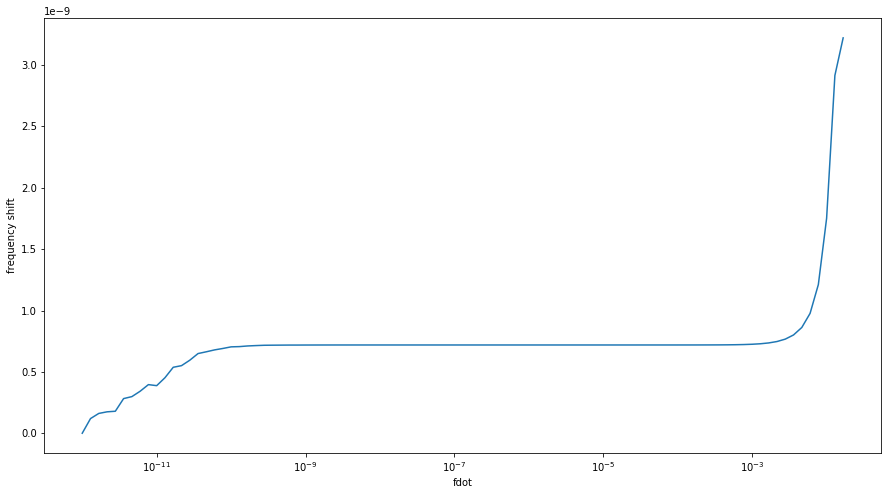

In [1396]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(fdots[7:],fdot_diff[7:])
ax.set_xscale("log")
ax.set_xlabel("fdot")
ax.set_ylabel("frequency shift")

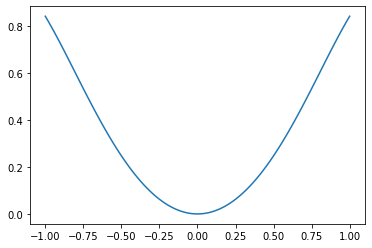

In [1298]:
fig,ax = plt.subplots()
x = np.linspace(-1,1,100)
ax.plot(x,np.sin(x**2))